# U-Net Segmentation - Camus Dataset

*Made by **Hang Jung Ling** and **Olivier Bernard** from the INSA Lyon, France.*

This notebook shows how to train, test and evaluate a U-Net to segment different cardiac structures on [CAMUS dataset](https://humanheart-project.creatis.insa-lyon.fr/database/#collection/6373703d73e9f0047faa1bc8).

CAMUS is one of the largest public echocardiogaphic datasets, with 500 patients and each patient has 4 echocardiographic images: end-diastolic (ED) and end-systolic (ES) frames acquired in both apical two chamber and apical four chamber views. Each image is annotated by an expert and contains 3 classes + background:</br>
&emsp;1) Left ventricle</br>
&emsp;2) Myocardium</br>
&emsp;3) Left atrium</br>

Summary :</br>
&emsp;I.   [Install dependencies](#install)</br>
&emsp;II.  [Dataset](#dataset)</br>
&emsp;II.  [Train](#train)</br>
&emsp;III. [Visualize learning curves and predictions](#visualize)</br>


# I. Install dependencies <a class="anchor" id="install"></a>

Kindly ignore this step if you have installed your own environment using `environment.yaml`. If not, please execute the following cells to install the dependencies.

In [1]:
%%capture project_path_setup

import sys

if "../" in sys.path:
    print(sys.path)
else:
    sys.path.append("../")
    print(sys.path)

In [2]:
%%capture packages_install

# Make sure the repo's package and its dependencies are installed
%pip install -e ../.

# II. Dataset <a class="anchor" id="dataset"></a>

Once the environment is successfully setup, download the CAMUS dataset by executing the following cell. The dataset will be downloaded to the `data/` folder. 

In [3]:
from pathlib import Path

from tqdm.auto import tqdm

# Make sure the data is downloaded and extracted where it should be
if not Path("../data/camus_64").is_dir():
    import zipfile
    from io import BytesIO
    from urllib.request import urlopen

    zipurl = "https://www.creatis.insa-lyon.fr/~bernard/camus/camus_64.zip"
    with urlopen(zipurl) as zipresp:
        with zipfile.ZipFile(BytesIO(zipresp.read())) as zfile:
            for member in tqdm(
                zfile.infolist(), desc="Downloading and extracting data", position=0, leave=True
            ):
                try:
                    zfile.extract(member, "../data/")
                except zipfile.error as e:
                    pass

Now, let's split these data into training, validation and testing sets. We will use 80% of the data for training, 10% for validation and 10% for testing. The split is done by patient ID, so that the same patient will not appear in different sets.

In [4]:
from pathlib import Path

from sklearn.model_selection import train_test_split

from src.utils.file_and_folder_operations import subdirs

# Specify the data directory
data_dir = Path("../data/camus_64").resolve()

# List all the patients id
keys = subdirs(data_dir, prefix="patient", join=False)

# Split the patients into 80/10/10 train/val/test sets
train_keys, val_and_test_keys = train_test_split(keys, train_size=0.8, random_state=12345)
val_keys, test_keys = train_test_split(val_and_test_keys, test_size=0.5, random_state=12345)

train_keys = sorted(train_keys)
val_keys = sorted(val_keys)
test_keys = sorted(test_keys)

# Create train, val and test datalist
viws_instants = ["2CH_ED", "2CH_ES", "4CH_ED", "4CH_ES"]
train_datalist = [
    {
        #"image": str(data_dir / key / f"{key}_{view}.nii.gz"),   we only take labels for the auto-encoder
        "label": str(data_dir / key / f"{key}_{view}_gt.nii.gz"),
    }
    for key in train_keys
    for view in viws_instants
]

val_datalist = [
    {
        #"image": str(data_dir / key / f"{key}_{view}.nii.gz"),
        "label": str(data_dir / key / f"{key}_{view}_gt.nii.gz"),
    }
    for key in val_keys
    for view in viws_instants
]

test_datalist = [
    {
        #"image": str(data_dir / key / f"{key}_{view}.nii.gz"),
        "label": str(data_dir / key / f"{key}_{view}_gt.nii.gz"),
    }
    for key in test_keys
    for view in viws_instants
]

print("Example of train keys: ", train_datalist[:2])
print("Example of validation keys: ", val_datalist[:2])
print("Example of test keys: ", test_datalist[:2])

Example of train keys:  [{'label': '/home/eblaszczyk/Bureau/TDSI/PTI/Auto_Encoder/auto-encoder-PTI/data/camus_64/patient0001/patient0001_2CH_ED_gt.nii.gz'}, {'label': '/home/eblaszczyk/Bureau/TDSI/PTI/Auto_Encoder/auto-encoder-PTI/data/camus_64/patient0001/patient0001_2CH_ES_gt.nii.gz'}]
Example of validation keys:  [{'label': '/home/eblaszczyk/Bureau/TDSI/PTI/Auto_Encoder/auto-encoder-PTI/data/camus_64/patient0012/patient0012_2CH_ED_gt.nii.gz'}, {'label': '/home/eblaszczyk/Bureau/TDSI/PTI/Auto_Encoder/auto-encoder-PTI/data/camus_64/patient0012/patient0012_2CH_ES_gt.nii.gz'}]
Example of test keys:  [{'label': '/home/eblaszczyk/Bureau/TDSI/PTI/Auto_Encoder/auto-encoder-PTI/data/camus_64/patient0010/patient0010_2CH_ED_gt.nii.gz'}, {'label': '/home/eblaszczyk/Bureau/TDSI/PTI/Auto_Encoder/auto-encoder-PTI/data/camus_64/patient0010/patient0010_2CH_ES_gt.nii.gz'}]


Once the data is split, we will create a `Dataset` object for each set. This object will be used to load the data during training and testing.

In [5]:
import numpy as np
from monai.data import CacheDataset
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    LoadImaged,
    NormalizeIntensityd,
    RandAdjustContrastd,
    RandFlipd,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandRotated,
    RandScaleIntensityd,
    RandZoomd,
)

# Transforms to load data
load_transforms = [
    #LoadImaged(keys=["image", "label"], image_only=True),  # Load image and label
    #EnsureChannelFirstd(
    #    keys=["image", "label"]
    #),  # Make sure the first dimension is the channel dimension
    #NormalizeIntensityd(keys=["image"]),  # Normalize the intensity of the image
    LoadImaged(keys="label", image_only=True),
    EnsureChannelFirstd(keys="label"),
]

# Transforms to augment data
range_x = [-15.0 / 180 * np.pi, 15.0 / 180 * np.pi]
data_augmentation_transforms = [
    RandRotated(
        #keys=["image", "label"],
        keys="label",
        range_x=range_x,
        range_y=0,
        range_z=0,
        #mode=["bicubic", "nearest"],
        mode="nearest",
        padding_mode="zeros",
        prob=0.2,
    ),
    RandZoomd(
        #keys=["image", "label"],
        keys="label",
        min_zoom=0.7,
        max_zoom=1.4,
        #mode=["bicubic", "nearest"],
        mode="nearest",
        padding_mode="constant",
        #align_corners=None,
        align_corners=None,
        prob=0.2,
    ),
    #RandGaussianNoised(keys=["image"], std=0.01, prob=0.15),
    #RandGaussianSmoothd(
    #    keys=["image"],
    #    sigma_x=(0.5, 1.15),
    #    sigma_y=(0.5, 1.15),
    #    prob=0.15,
    #),
    #RandScaleIntensityd(keys=["image"], factors=0.3, prob=0.15),
    #RandAdjustContrastd(keys=["image"], gamma=(0.7, 1.5), prob=0.3),
    #RandFlipd(keys=["image", "label"], spatial_axis=[0], prob=0.5),
    RandFlipd(keys="label", spatial_axis=[0], prob=0.5),
]

# Define transforms for training, validation and testing
train_transforms = Compose(load_transforms + data_augmentation_transforms)
val_transforms = Compose(load_transforms)
test_transforms = Compose(load_transforms)

# Use CacheDataset to accelerate training and validation
train_ds = CacheDataset(data=train_datalist, transform=train_transforms, cache_rate=1.0)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms, cache_rate=1.0)
test_ds = CacheDataset(data=test_datalist, transform=test_transforms, cache_rate=1.0)

/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Loading dataset: 100%|███████████████████████| 200/200 [00:01<00:00, 145.01it/s]


Now, let's visualize some images from the training set. The images are displayed with their corresponding ground truth segmentation masks.

train_idx:  57
val_idx:  186
test_idx:  112


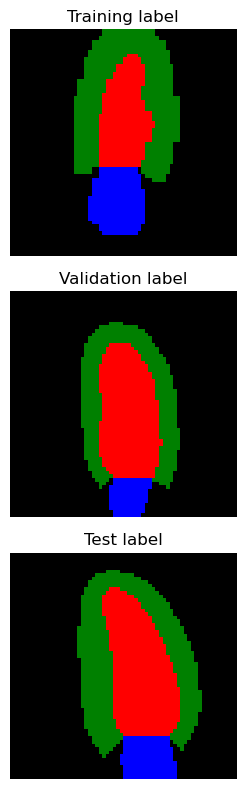

In [6]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

from src.utils.visualizations import imagesc

# Get a random index to display the image with label from each dataset
train_idx = np.random.randint(len(train_ds))
val_idx = np.random.randint(len(val_ds))
test_idx = np.random.randint(len(test_ds))

# Print the selected indices
print("train_idx: ", train_idx)
print("val_idx: ", val_idx)
print("test_idx: ", test_idx)

# Visualize a random image with label from each dataset
colors = ["black", "red", "green", "blue"]
cmap = ListedColormap(colors)

figure = plt.figure(figsize=(8, 8))
train_sample = train_ds[train_idx]
#image = train_sample["image"].detach().cpu().numpy()[0].transpose(1, 0)
label = train_sample["label"].detach().cpu().numpy()[0].transpose(1, 0)
ax = figure.add_subplot(3, 2, 1)
#imagesc(ax, image, title="Training image", show_colorbar=False)
#ax = figure.add_subplot(3, 2, 2)
imagesc(
    ax, label, title="Training label", show_colorbar=False, colormap=cmap, interpolation="nearest"
)

val_sample = val_ds[val_idx]
#image = val_sample["image"].detach().cpu().numpy()[0].transpose(1, 0)
label = val_sample["label"].detach().cpu().numpy()[0].transpose(1, 0)
ax = figure.add_subplot(3, 2, 3)
#imagesc(ax, image, title="Validation image", show_colorbar=False)
#ax = figure.add_subplot(3, 2, 4)
imagesc(
    ax,
    label,
    title="Validation label",
    show_colorbar=False,
    colormap=cmap,
    interpolation="nearest",
)

test_sample = test_ds[test_idx]
#image = test_sample["image"].detach().cpu().numpy()[0].transpose(1, 0)
label = test_sample["label"].detach().cpu().numpy()[0].transpose(1, 0)
ax = figure.add_subplot(3, 2, 5)
#imagesc(ax, image, title="Test image", show_colorbar=False)
#ax = figure.add_subplot(3, 2, 6)
imagesc(ax, label, title="Test label", show_colorbar=False, colormap=cmap, interpolation="nearest")
figure.tight_layout()
plt.show()

# III. Train <a class="anchor" id="train"></a>
Let's move on to train a U-Net to segment the left ventricle, myocardium and left atrium. We will use the training and validation sets created in the previous section.

### Definition of U-Net architecture

In [7]:
from torchinfo import summary

from src.models.autoencoder import Auto_Encoder

input_channels = 1  # This is the number of input channels in the image
input_shape = (input_channels, 64, 64)  # This is the shape of the input image to the network
num_classes = 4  # This is the number of output classes
output_shape = (num_classes, 64, 64)  # This is the shape of the output mask
init_channels = 32  # This is the number of channels in the first layer of the network

autoencoder = Auto_Encoder(input_shape=input_shape, output_shape=output_shape, init_channels=init_channels)

# Print the summary of the network
summary_kwargs = dict(
    col_names=["input_size", "output_size", "kernel_size", "num_params"], depth=3, verbose=0
)
summary(autoencoder, (1, *input_shape), device="cpu", **summary_kwargs) #REMPLACER CUDA PAR CPU SI PROBLEMES

Layer (type:depth-idx)                        Input Shape               Output Shape              Kernel Shape              Param #
Auto_Encoder                                  [1, 1, 64, 64]            [1, 4, 64, 64]            --                        --
├─_DoubleConv: 1-1                            [1, 1, 64, 64]            [1, 16, 64, 64]           --                        --
│    └─Sequential: 2-1                        [1, 1, 64, 64]            [1, 16, 64, 64]           --                        --
│    │    └─Conv2d: 3-1                       [1, 1, 64, 64]            [1, 16, 64, 64]           [3, 3]                    160
│    │    └─BatchNorm2d: 3-2                  [1, 16, 64, 64]           [1, 16, 64, 64]           --                        32
│    │    └─ReLU: 3-3                         [1, 16, 64, 64]           [1, 16, 64, 64]           --                        --
│    │    └─Dropout: 3-4                      [1, 16, 64, 64]           [1, 16, 64, 64]           --     

### Definition of optimizer and loss function
We will use the Adam optimizer. The loss function is the L2, which is a standard loss function for auto-encoders.


In [8]:
from functools import partial

import torch

#from src.utils.loss_functions.dice_loss import DC_and_CE_loss

# Soft dice and CE loss function
#loss_function = DC_and_CE_loss(
#    {"batch_dice": True, "smooth": 1e-5, "do_bg": False}, weight_ce=1, weight_dice=1
#)
loss_function = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')

# Adam optimizer
optimizer = partial(torch.optim.Adam, params=autoencoder.parameters())

### Definition of training function

In [9]:
import os
import time
from typing import Union

import torch.nn.functional as F
from monai.data import DataLoader
from torch import nn
from torch.utils.data import Dataset
from tqdm.auto import tqdm

from src.utils.tensor_utils import sum_tensor


def train_process(
    train_ds: Dataset,
    val_ds: Dataset,
    num_workers: int,
    model: nn.Module,
    loss_function: nn.Module,
    optimizer: torch.optim.Optimizer,
    num_classes: int,
    batch_size: int = 2,
    lr: float = 0.001,
    max_epochs: int = 30,
    log_dir: Union[Path, str] = Path("../logs/camus_segmentation"),
    val_interval=1,
) -> tuple[float, list[float], list[float], list[int], list[float]]:
    """Trains a neural network model for segmentation on the provided datasets using the specified parameters.

    Args:
        train_ds: Training dataset.
        val_ds: Validation dataset.
        num_workers: Number of workers to use for data loading.
        model: Neural network model.
        loss_function: Loss function.
        optimizer: Optimizer.
        num_classes: Number of classes to segment.
        batch_size: Number of batch size. Defaults to 2.
        lr: Learning rate. Defaults to 0.001.
        max_epochs: Maximum training epochs. Defaults to 30.
        log_dir: Path to the logging directory. Defaults to Path("../logs/camus_segmentation").
        val_interval: Epoch interval to perform evaluation steps. Defaults to 1.

    Returns:
        - Total time taken for training.
        - List containing training loss values for each epoch.
        - List containing validation loss values for each evaluation epoch.
        - List containing epochs where validation is performed.
        - List containing metric values for each evaluation epoch.
    """
    # Create train and validation dataloaders
    train_dataloader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available(),
    )
    val_dataloader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available(),
    )

    # Determine the device to run the model on
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"GPU detected, training on: {device}!\n")
    else:
        device = torch.device("cpu")
        print("GPU not detected, training on CPU!\n")

    # Move the model to the device
    model = model.to(device)

    # Finalize the creation of the optimizer object with the learning rate
    optimizer = optimizer(lr=lr)

    # Convert log directory to Path object if needed
    if not isinstance(log_dir, Path):
        log_dir = Path(log_dir)
    # Create the log directory if it does not exist
    log_dir.mkdir(parents=True, exist_ok=True)

    # Define some variables to keep track of the best metric values, epoch time and losses
    best_metric = 0
    best_metric_epoch = 0
    epoch_train_loss_values = []
    epoch_val_loss_values = []
    metric_values = []
    epoch_val = []
    metric_per_class = {f"metric/{i}": [] for i in range(1, num_classes)}
    total_start = time.time()

    fit_pbar = tqdm(range(max_epochs), desc="Training", unit="epoch", position=0, leave=True)
    pbar_metrics = {"train/loss": None, "val/loss": None, "val/dice": None}

    for epoch in fit_pbar:
        model.train()
        epoch_loss = 0
        epoch_val_loss = 0
        step = 0
        epoch_tp_hard = []
        epoch_fp_hard = []
        epoch_fn_hard = []
        for batch_data in train_dataloader:
            step += 1
            #inputs, labels = (
            #    batch_data["image"].to(device),
            #    batch_data["label"].to(device),
            #)
            labels = batch_data["label"].to(device),
            optimizer.zero_grad()
            #outputs = model(inputs)
            outputs = model(labels)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar_metrics["loss"] = loss.item()
            pbar_metrics["train_batch"] = f"{step}/{len(train_dataloader)}"
            fit_pbar.set_postfix(pbar_metrics)

        epoch_loss /= step
        epoch_train_loss_values.append(epoch_loss)
        pbar_metrics["train/loss"] = epoch_loss
        pbar_metrics.pop("loss")
        pbar_metrics.pop("train_batch")
        fit_pbar.set_postfix(pbar_metrics)

        if (epoch + 1) % val_interval == 0:
            step = 0
            model.eval()
            with torch.no_grad():
                for val_data in val_dataloader:
                    step += 1
                    #val_inputs, val_labels = (
                    #    val_data["image"].to(device),
                    #    val_data["label"].to(device),
                    #)
                    val_labels = val_data["label"].to(device)
                    val_outputs = model(val_labels)
                    val_loss = loss_function(val_outputs, val_labels)
                    epoch_val_loss += val_loss.item()
                    pbar_metrics["loss"] = val_loss.item()
                    pbar_metrics["val_batch"] = f"{step}/{len(val_dataloader)}"
                    fit_pbar.set_postfix(pbar_metrics)

                    # Compute tp, fp, and fn that will be used to compute the hard dice metric per epoch
                    val_labels = val_labels[:, 0]
                    axes = tuple(range(1, len(val_labels.shape)))
                    # Convert the output logits to a segmentation mask
                    val_outputs = F.softmax(val_outputs, dim=1).argmax(dim=1)

                    tp_hard = torch.zeros((val_labels.shape[0], num_classes - 1)).to(
                        val_outputs.device.index
                    )
                    fp_hard = torch.zeros((val_labels.shape[0], num_classes - 1)).to(
                        val_outputs.device.index
                    )
                    fn_hard = torch.zeros((val_labels.shape[0], num_classes - 1)).to(
                        val_outputs.device.index
                    )

                    for c in range(1, num_classes):
                        tp_hard[:, c - 1] = sum_tensor(
                            (val_outputs == c).float() * (val_labels == c).float(), axes=axes
                        )
                        fp_hard[:, c - 1] = sum_tensor(
                            (val_outputs == c).float() * (val_labels != c).float(), axes=axes
                        )
                        fn_hard[:, c - 1] = sum_tensor(
                            (val_outputs != c).float() * (val_labels == c).float(), axes=axes
                        )

                    tp_hard = tp_hard.sum(0, keepdim=False).detach().cpu().numpy()
                    fp_hard = fp_hard.sum(0, keepdim=False).detach().cpu().numpy()
                    fn_hard = fn_hard.sum(0, keepdim=False).detach().cpu().numpy()

                    # Store the tp_hard, fp_hard, and fn_hard per evaluation step
                    epoch_tp_hard.append(list(tp_hard))
                    epoch_fp_hard.append(list(fp_hard))
                    epoch_fn_hard.append(list(fn_hard))

                epoch_val_loss /= step
                epoch_val_loss_values.append(epoch_val_loss)
                epoch_val.append(epoch + 1)
                pbar_metrics.pop("loss")
                pbar_metrics.pop("val_batch")
                pbar_metrics["val/loss"] = float(epoch_val_loss)

                # Compute the hard dice metric per epoch
                epoch_tp_hard = np.sum(epoch_tp_hard, 0)
                epoch_fp_hard = np.sum(epoch_fp_hard, 0)
                epoch_fn_hard = np.sum(epoch_fn_hard, 0)

                # Compute the hard dice metric per class
                global_dc_per_class = [
                    i if not np.isnan(i) else 0.0
                    for i in [
                        2 * i / (2 * i + j + k)
                        for i, j, k in zip(epoch_tp_hard, epoch_fp_hard, epoch_fn_hard)
                    ]
                ]

                val_metric = np.mean(global_dc_per_class)
                metric_values.append(val_metric)
                pbar_metrics["val/dice"] = val_metric
                for i in range(1, num_classes, 1):
                    pbar_metrics[f"val/dice/{i}"] = global_dc_per_class[i - 1]
                    metric_per_class[f"metric/{i}"].append(global_dc_per_class[i - 1])
                fit_pbar.set_postfix(pbar_metrics)

                if val_metric > best_metric:
                    best_metric = val_metric
                    best_metric_epoch = epoch + 1
                    # Save best metric model checkpoint
                    torch.save(
                        {
                            "max_epochs": max_epochs,
                            "current_epoch": epoch + 1,
                            "best_metric_epoch": best_metric_epoch,
                            "train_loss": epoch_train_loss_values,
                            "val_loss": epoch_val_loss_values,
                            "epoch_val": epoch_val,
                            "metric_values": metric_values,
                            "metric_per_class": metric_per_class,
                            "model_state_dict": model.state_dict(),
                            "optimizer_state_dict": optimizer.state_dict(),
                        },
                        str(log_dir / "best_metric_model.pth"),
                    )

        # Save last model checkpoint
        torch.save(
            {
                "max_epochs": max_epochs,
                "current_epoch": epoch + 1,
                "best_metric_epoch": best_metric_epoch,
                "train_loss": epoch_train_loss_values,
                "val_loss": epoch_val_loss_values,
                "epoch_val": epoch_val,
                "metric_values": metric_values,
                "metric_per_class": metric_per_class,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
            str(log_dir / "last_model.pth"),
        )

    print(
        f"train completed, best_metric: {best_metric:.4f}"
        f" at epoch: {best_metric_epoch}"
        f" total time: {(time.time() - total_start):.4f}"
    )
    return (
        time.time() - total_start,
        epoch_train_loss_values,
        epoch_val_loss_values,
        epoch_val,
        metric_values,
        metric_per_class,
    )

### Definition of training hyperparameters
In this section, we will define the hyperparameters for training, such as the number of epochs, the learning rate, the batch size, etc.

In [10]:
batch_size = 2  # Number of batch size
lr = 0.001  # Learning rate
max_epochs = 10  # Number of epochs to train the model
num_workers = os.cpu_count() - 1  # Number of workers to use for data loading

# Train the model
(
    total_time,
    epoch_train_loss_values,
    epoch_val_loss_values,
    epoch_val,
    metric_values,
    metric_per_class,
) = train_process(
    train_ds=train_ds,
    val_ds=val_ds,
    num_workers=num_workers,
    model=autoencoder,
    loss_function=loss_function,
    optimizer=optimizer,
    num_classes=num_classes,
    batch_size=batch_size,
    lr=lr,
    max_epochs=max_epochs,
    log_dir="../logs/camus_segmentation",
)

GPU not detected, training on CPU!



Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

TypeError: conv2d() received an invalid combination of arguments - got (tuple, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!tuple!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!tuple!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


# IV. Visualize learning curves and predictions <a class="anchor" id="visualize"></a>

### Plot training losses, validation losses and validation dice over epochs

In [ ]:
from matplotlib.ticker import MaxNLocator

trains_epoch = list(range(1, max_epochs + 1, 1))
vals_epochs = epoch_val

plt.figure("train", (16, 8))
ax = plt.subplot(1, 3, 1)
plt.title("Epoch Average Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
plt.plot(trains_epoch, epoch_train_loss_values, color="red", label="Train")
plt.plot(vals_epochs, epoch_val_loss_values, color="blue", label="Val")
plt.legend(loc="upper right")
ax = plt.subplot(1, 3, 2)
plt.title("Val Mean Dice")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
plt.plot(vals_epochs, metric_values, color="green")

ax = plt.subplot(1, 3, 3)
plt.title("Val Mean Dice per Class")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
legend_metric = ["left ventricle", "myocardium", "left atrium"]
for i in range(1, num_classes, 1):
    plt.plot(vals_epochs, metric_per_class[f"metric/{i}"], label=legend_metric[i - 1])
plt.legend(loc="upper left")
plt.show()

### Download the pre-trained model weight for 50 epochs and visualize learning curves and metrics over 50 epochs

In [ ]:
from matplotlib.ticker import MaxNLocator

# Path to the logging directory
log_dir = "../logs/camus_segmentation"

# Determine the device to run the model on
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Load the best model weight
best_model = Path(log_dir) / "best_model_50epochs.pth"
if not best_model.is_file():
    import urllib.request

    urllib.request.urlretrieve(
        "https://www.creatis.insa-lyon.fr/~bernard/camus/best_model_50epochs.pth",
        str(best_model),
    )

# Load the weight
weight = torch.load(best_model, map_location=device)
epoch_train_loss_values = weight["train_loss"]
epoch_val_loss_values = weight["val_loss"]
epoch_val = weight["epoch_val"]
metric_values = weight["metric_values"]
metric_per_class = weight["metric_per_class"]
max_epochs = weight["max_epochs"]
best_metric_epoch = weight["best_metric_epoch"]

# Plot the training losses, validation losses and validation dice over epochs
trains_epoch = list(range(1, max_epochs + 1, 1))
vals_epochs = epoch_val

plt.figure("train", (16, 8))
ax = plt.subplot(1, 3, 1)
plt.title("Epoch Average Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
plt.plot(trains_epoch, epoch_train_loss_values, color="red", label="Train")
plt.plot(vals_epochs, epoch_val_loss_values, color="blue", label="Val")
# Add a vertical line at the best model epoch
plt.axvline(best_metric_epoch, color="gray", linestyle="--")
plt.text(
    best_metric_epoch + 0.5,
    min(epoch_train_loss_values) * 4 / 5,
    f"Best model epoch = {best_metric_epoch}",
    rotation=90,
)
plt.legend(loc="upper right")
ax = plt.subplot(1, 3, 2)
plt.title("Val Mean Dice")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
plt.plot(vals_epochs, metric_values, color="green")
plt.axvline(best_metric_epoch, color="gray", linestyle="--")

ax = plt.subplot(1, 3, 3)
plt.title("Val Mean Dice per Class")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer ticks for x-axis
legend_metric = ["left ventricle", "myocardium", "left atrium"]
for i in range(1, num_classes, 1):
    plt.plot(vals_epochs, metric_per_class[f"metric/{i}"], label=legend_metric[i - 1])
plt.axvline(best_metric_epoch, color="gray", linestyle="--")
plt.legend(loc="upper left")
plt.show()

### Load the pre-trained model weight into the U-Net

In [ ]:
# Set to True to use the pretrained model
# Set to False to use the model you just trained
use_pretrained = False

if use_pretrained:
    weight = torch.load(Path(log_dir) / "best_model_50epochs.pth", map_location=device)
else:
    weight = torch.load(Path(log_dir) / "best_metric_model.pth", map_location=device)

# Load the weight into the U-Net
autoencoder.load_state_dict(weight["model_state_dict"])
# Move the U-Net to the correct device
autoencoder.to(device)
# Put the U-Net in evaluation mode
autoencoder.eval()

### Perform the inference on the test set
First, we create the dataloader from the test dataset we defined at the beginning.

In [ ]:
# Create the test dataloader
num_workers = os.cpu_count() - 1

test_dataloader = DataLoader(
    test_ds,
    batch_size=1,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

# Create an iterator to iterate over the test dataloader
test_dataloader_iter = iter(test_dataloader)

Then, we perform the inference on a sample from the test dataset and plot the prediction.

In [ ]:
# Run inference on a test image
batch_data = next(test_dataloader_iter)
with torch.no_grad():
    image = batch_data["image"].to(device)
    pred = autoencoder(image)
    pred = F.softmax(pred, dim=1).argmax(dim=1)
    pred = pred.squeeze().detach().cpu().numpy().transpose(1, 0)
    label = batch_data["label"].squeeze().detach().cpu().numpy().transpose(1, 0)
    image = image.squeeze().detach().cpu().numpy().transpose(1, 0)

# Plot the image, label and prediction
figure = plt.figure(figsize=(8, 8))
ax = figure.add_subplot(1, 3, 1)
imagesc(ax, image, title="Image", show_colorbar=False)
ax = figure.add_subplot(1, 3, 2)
imagesc(ax, label, title="Label", show_colorbar=False, colormap=cmap, interpolation="nearest")
ax = figure.add_subplot(1, 3, 3)
imagesc(ax, pred, title="Prediction", show_colorbar=False, colormap=cmap, interpolation="nearest")
figure.tight_layout()
plt.show()